In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
sys.path.append('../problems/')
sys.path.append('../scripts/')
sys.path.append('../scripts/dataset_generation/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint
from factorization import Factorization
from train_model import get_loaders


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 20)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/factorization/2^22/scaled/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/factorization/2^22/scaled/checkpoints/389150_0.0727.pt


In [7]:
args = checkpoint['args']

In [8]:
problem = Factorization(args)

In [9]:
t = problem.get_tokenizer()

In [10]:
args.keys()

dict_keys(['data', 'problem_type', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [11]:
model = models.Seq2SeqModel(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Seq2SeqModel(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=256, out_features=256, bias=False)
            (w_k): Linear(in_features=256, out_features=256, bias=False)
            (w_v): Linear(in_features=256, out_features=256, bias=False)
            (out_proj): Linear(in_features=256, out_features=256, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (w_k_pos): Linear(in_features=256, out_features=256, bias=False)
          )
          (linear1): Linear(in_features=256,

## Model Performance

In [12]:
for key in ['train', 'test', 'oos']:
    if not args['data'][f'{key}_path'].startswith('streaming_'):
        args['data'][f'{key}_path'] = '../' + args['data'][f'{key}_path']

In [13]:
train_loader, test_loader, oos_loader = get_loaders(problem)

Loading data...


In [14]:
test_df, test_metrics = problem.compute_metrics(model, device, test_loader, save=False, n_beams=64)

  0%|          | 0/209624 [00:00<?, ?it/s]

../problems\factorization.py:90: RuntimeWarning: invalid value encountered in double_scalars
  information['percent_prime_factors_pred'] = information['num_prime_factors_pred'] / information['num_pred_factors']


  0%|          | 0/819 [00:00<?, ?it/s]

In [16]:
import json
with open('factorization_scaled_test_metrics_64.json', 'w') as f:
    json.dump(test_metrics, f)

In [15]:
test_df.to_csv('factorization_scaled_test_preds_64.csv')

In [17]:
test_metrics

{'correct': {'correct_product': 1.0,
  'correct_factorization': 0.963286646567187},
 'beam_accuracy': {'correct_product': {0: 0.9901776514139602,
   1: 0.15494409037133153,
   2: 0.07555909628668474,
   3: 0.050862496660687706,
   4: 0.03734305232225318,
   5: 0.028594054115940924,
   6: 0.02238293325191772,
   7: 0.019215357020188527,
   8: 0.01513185513109186,
   9: 0.01343357630805633,
   10: 0.011949967560966302,
   11: 0.01083368316604969,
   12: 0.009383467541884518,
   13: 0.008190856008853949,
   14: 0.007790138533755677,
   15: 0.0075754684578101745,
   16: 0.006983933137427012,
   17: 0.0065593634316681295,
   18: 0.006048925695531046,
   19: 0.005967828111284967,
   20: 0.005629126435904286,
   21: 0.0052856543143914815,
   22: 0.005032820669389001,
   23: 0.004894477731557456,
   24: 0.004598710071365874,
   25: 0.0044508262412700835,
   26: 0.004264778842117315,
   27: 0.003959470289661489,
   28: 0.004002404304850589,
   29: 0.003678013967866275,
   30: 0.0036398503988092

# Visualize Embeddings

In [18]:
embeddings = model.src_embedding.embedding.weight.data.cpu().numpy()

In [19]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(problem.special_tokens)
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [20]:
embeddings.shape

(34, 256)

In [21]:
tokens.shape

(34,)

In [22]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '*', '[PAD]', '[EOS]', '[SOS]'],
      dtype='<U11')

## TSNE
* Doesn't seem to be super interesting (over more paramaters than these)

In [23]:
from sklearn.manifold import TSNE

In [24]:
tsne = TSNE()#perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

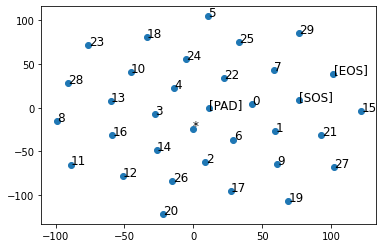

In [25]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

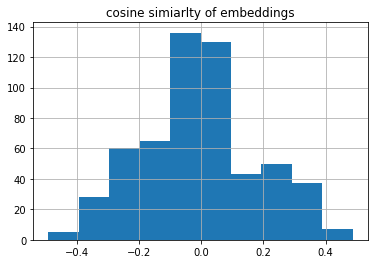

In [28]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [29]:
cs_sim_mat.shape

(34, 34)

In [30]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '*', '[PAD]', '[EOS]', '[SOS]'],
      dtype='<U11')

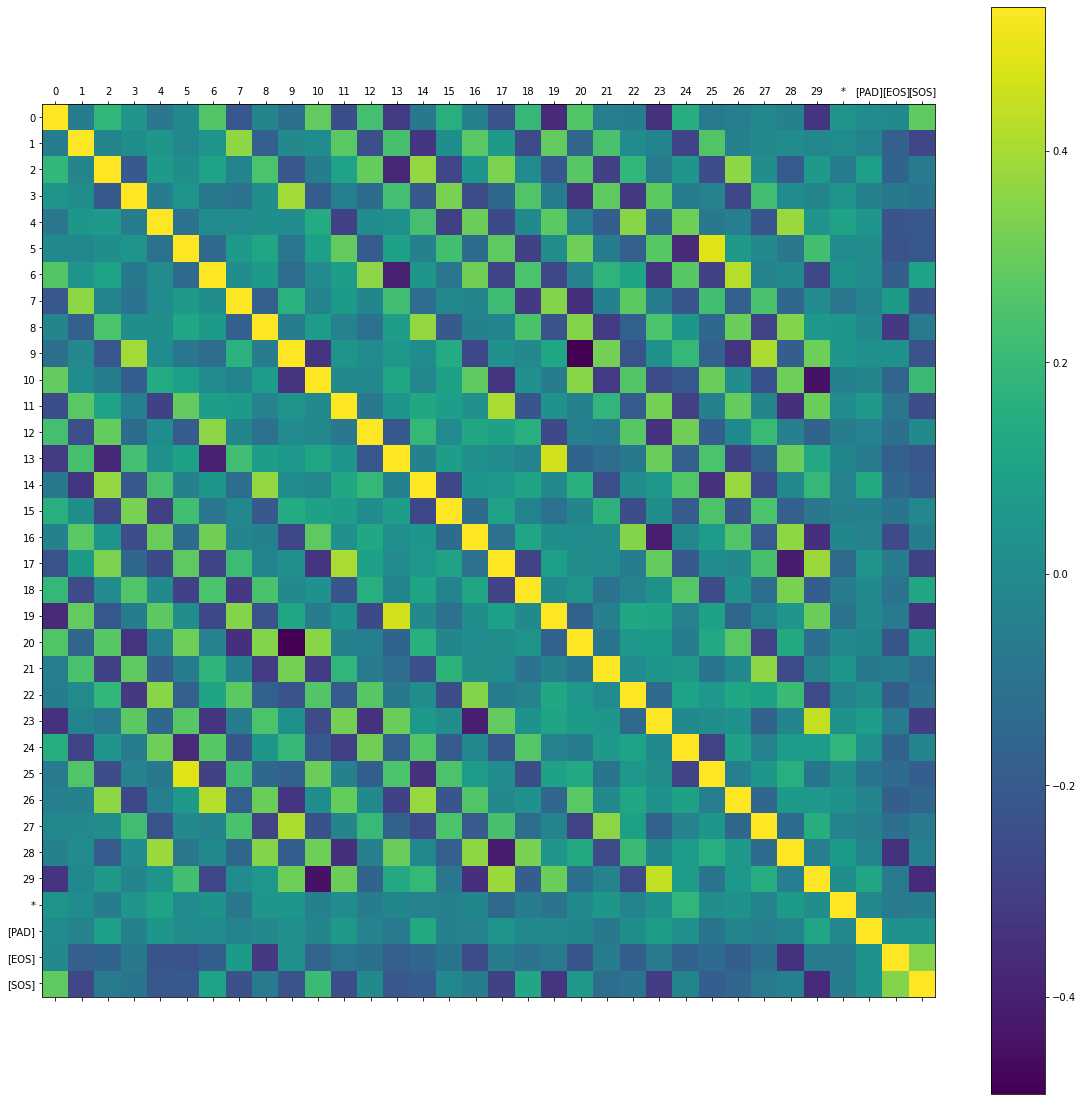

In [31]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(cs_sim_mat, a_min=-1, a_max=cs_sim_mat[cs_sim_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(cs_sim_mat.shape[0]))
ax.set_yticks(np.arange(cs_sim_mat.shape[0]))
ax.set_xticklabels(tokens[:cs_sim_mat.shape[0]])
ax.set_yticklabels(tokens[:cs_sim_mat.shape[0]])
plt.show()

### Are the embeddings linearly predictive of anything interesting?

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [33]:
logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
# logreg = SVC()

In [34]:
embeddings.shape, tokens.shape

((34, 256), (34,))

In [35]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [36]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [37]:
logreg_x_train.shape, logreg_y_train.shape

((23, 256), (23,))

In [38]:
logreg_x_test.shape, logreg_y_test.shape

((7, 256), (7,))

In [39]:
logreg.fit(logreg_x_train, logreg_y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [40]:
logreg.score(logreg_x_train, logreg_y_train)

0.5217391304347826

In [41]:
logreg.score(logreg_x_test, logreg_y_test)

0.42857142857142855

# How well does the model do on numbers higher than what it was trained on?

In [42]:
start = 2**22
length = 1024
numbers = np.arange(start, start + length)

In [43]:
t

In [44]:
larger_df = problem.form_prediction_df(model, device, numbers, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/1024 [00:00<?, ?it/s]

../problems\factorization.py:90: RuntimeWarning: invalid value encountered in double_scalars
  information['percent_prime_factors_pred'] = information['num_prime_factors_pred'] / information['num_pred_factors']


In [45]:
larger_df.shape

(10240, 18)

In [46]:
larger_df.head(10)

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",0,-0.464921,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",0.000000e+00,32,32.0,1.000000,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
1,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",1,-3.776376,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 17 [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 17]",4.456448e+06,19,19.0,1.000000,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
2,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",2,-4.664926,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 13,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 13]",-2.147484e+09,32,32.0,1.000000,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
3,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",3,-4.709636,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 13 2 *,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 392]",0.000000e+00,31,30.0,0.967742,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
4,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",4,-4.746852,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 13 2 * 2 * 2 *,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 392, 2, 2]",0.000000e+00,31,30.0,0.967742,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
5,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",5,-4.898310,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 13 2 * 2 *,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 392, 2]",0.000000e+00,31,30.0,0.967742,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
6,4194304,"[[SOS], 5, 5, 10, 10, 4, [EOS]]",6,-4.910382,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 13 2 * 2 * 2 * 2 * 2 *,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 392, 2, 2, 2, 2]",0.000000e+00,31,30.0,0.967742,False,False,False,False,[SOS] 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 * 2 [EOS],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",22,2
7,4194304,"[[SOS], 5, 5, 10, 10,

In [47]:
larger_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.765625
dtype: float64

In [48]:
top_beams = larger_df['beam_idx'] == 8
# just picking 8 as a random beam, do higher beams tend to over or underpredict? hypothetically under is more frequent since model is trained to predict smaller numbers
(larger_df[top_beams]['product'] < larger_df[top_beams]['input_num']).mean()

0.4462890625

### how does it handle squares/cubes/...?

In [49]:
from sympy import factorint
from sympy.ntheory import primerange

In [50]:
max_num = 256
squares = np.array(list(primerange(2, max_num)))**2
cubes = np.array(list(primerange(2, max_num)))**3

In [51]:
square_df = problem.form_prediction_df(model, device, squares, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/54 [00:00<?, ?it/s]

In [52]:
square_df[square_df['beam_idx']==0]['correct_factorization'].mean()

0.1111111111111111

In [53]:
square_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.592593
dtype: float64

In [54]:
square_df

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,4,"[[SOS], 4, [EOS]]",0,-0.000280,[SOS] 2 * 2 [EOS] [PAD] [PAD] [PAD],"[2, 2]",4,2,2,1.0,True,True,False,False,[SOS] 2 * 2 [EOS],"[2, 2]",2,2
1,4,"[[SOS], 4, [EOS]]",1,-8.205846,[SOS] 2 * 2 * 1 1 [EOS],"[2, 2, 31]",124,3,3,1.0,False,False,False,False,[SOS] 2 * 2 [EOS],"[2, 2]",2,2
2,4,"[[SOS], 4, [EOS]]",2,-9.210621,[SOS] 2 * 2 [EOS] [PAD] [PAD] 0,"[2, 60]",120,2,1,0.5,False,False,False,False,[SOS] 2 * 2 [EOS],"[2, 2]",2,2
3,4,"[[SOS], 4, [EOS]]",3,-9.210621,[SOS] 2 * 2 [EOS] [PAD] [PAD] 1,"[2, 61]",122,2,2,1.0,False,False,False,False,[SOS] 2 * 2 [EOS],"[2, 2]",2,2
4,4,"[[SOS], 4, [EOS]]",4,-9.210621,[SOS] 2 * 2 [EOS] [PAD] [PAD] 2,"[2, 62]",124,2,1,0.5,False,False,False,False,[SOS] 2 * 2 [EOS],"[2, 2]",2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,63001,"[[SOS], 2, 10, 0, 1, [EOS]]",5,-3.138722,[SOS] 2 11 * 29 11 [EOS] [PAD] [PAD],"[71, 881]",62551,2,2,1.0,False,False,False,False,[SOS] 8 11 * 8 11 [EOS],"[251, 251]",2,251
536,63001,"[[SOS], 2, 10, 0, 1, [EOS]]",6,-3.304835,[SOS] 17 * 1 7 * 3 11 [EOS],"[17, 37, 101]",63529,3,3,1.0,False,False,False,False,[SOS] 8 11 * 8 11 [EOS],"[251, 251]",2,251
537,63001,"[[SOS], 2, 10, 0, 1, [EOS]]",7,-3.326592,[SOS] 19 * 3 20 19 [EOS] [PAD] [PAD],"[19, 3319]",63061,2,2,1.0,False,False,False,False,[SOS] 8 11 * 8 11 [EOS],"[251, 251]",2,251
538,63001,"[[SOS], 2, 10, 0, 1, [EOS]]",8,-3.552692,[SOS] 23 * 1 11 * 2 7 [EOS],"[23, 41, 67]",63181,3,3,1.0,False,False,False,False,[SOS] 8 11 * 8 11 [EOS],"[251, 251]",2,251


In [55]:
cube_df = problem.form_prediction_df(model, device, cubes, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/54 [00:00<?, ?it/s]

In [56]:
cube_df[cube_df['beam_idx']==0]['correct_factorization'].mean()

0.09259259259259259

In [57]:
cube_df[cube_df['beam_idx'] == 0].head(10)

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,8,"[[SOS], 8, [EOS]]",0,-0.001551,[SOS] 2 * 2 * 2 [EOS] [PAD] [PAD] [PAD],"[2, 2, 2]",8,3,3,1.0,True,True,False,False,[SOS] 2 * 2 * 2 [EOS],"[2, 2, 2]",3,2
10,27,"[[SOS], 27, [EOS]]",0,-0.000216,[SOS] 3 * 3 * 3 [EOS] [PAD] [PAD] [PAD],"[3, 3, 3]",27,3,3,1.0,True,True,False,False,[SOS] 3 * 3 * 3 [EOS],"[3, 3, 3]",3,3
20,125,"[[SOS], 4, 5, [EOS]]",0,-0.000183,[SOS] 5 * 5 * 5 [EOS] [PAD],"[5, 5, 5]",125,3,3,1.0,True,True,False,False,[SOS] 5 * 5 * 5 [EOS],"[5, 5, 5]",3,5
30,343,"[[SOS], 11, 13, [EOS]]",0,-1.034568,[SOS] 11 13 [EOS] [PAD] [PAD] [PAD],[343],343,1,0,0.0,True,False,False,False,[SOS] 7 * 7 * 7 [EOS],"[7, 7, 7]",3,7
40,1331,"[[SOS], 1, 14, 11, [EOS]]",0,-0.524708,[SOS] 1 14 11 [EOS] [PAD] [PAD],[1331],1331,1,0,0.0,True,False,False,False,[SOS] 11 * 11 * 11 [EOS],"[11, 11, 11]",3,11
50,2197,"[[SOS], 2, 13, 7, [EOS]]",0,-0.613068,[SOS] 2 13 7 [EOS] [PAD] [PAD],[2197],2197,1,0,0.0,True,False,False,False,[SOS] 13 * 13 * 13 [EOS],"[13, 13, 13]",3,13
60,4913,"[[SOS], 5, 13, 23, [EOS]]",0,-0.767244,[SOS] 5 13 23 [EOS] [PAD] [PAD],[4913],4913,1,0,0.0,True,False,False,False,[SOS] 17 * 17 * 17 [EOS],"[17, 17, 17]",3,17
70,6859,"[[SOS], 7, 18, 19, [EOS]]",0,-0.892139,[SOS] 7 18 19 [EOS] [PAD] [PAD] [PAD],[6859],6859,1,0,0.0,True,False,False,False,[SOS] 19 * 19 * 19 [EOS],"[19, 19, 19]",3,19
80,12167,"[[SOS], 13, 15, 17, [EOS]]",0,-0.593286,[SOS] 13 15 17 [EOS] [PAD] [PAD] [PAD],[12167],12167,1,0,0.0,True,False,False,False,[SOS] 23 * 23 * 23 [EOS],"[23, 23, 23]",3,23
90,24389,"[[SOS], 27, 2, 29, [EOS]]",0,-1.066110,[SOS] 27 2 29 [EOS] [PAD] [PAD] [PAD] [PAD],[24389],24389,1,0,0.0,True,False,False,False,[SOS] 29 * 29 * 29 [EOS],"[29, 29, 29]",3,29


In [58]:
cube_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.37037
dtype: float64

### When encoding two different numbers, what are the cosine similarities of their representations?

In [59]:
first_int = 16
second_int = 32

In [60]:
def get_reps_for_number(number):
    tokens = t.encode(problem.form_input(number, args['data']['base']))
    tens = torch.tensor(tokens).unsqueeze(0).to(device)
    memory, _ = model.encode(tens)
    return memory.squeeze().data.cpu().numpy(), tokens

In [61]:
first_reps, first_tokens = get_reps_for_number(first_int)
second_reps, second_tokens = get_reps_for_number(second_int)

In [62]:
cs_sims = cosine_similarity(first_reps, second_reps)

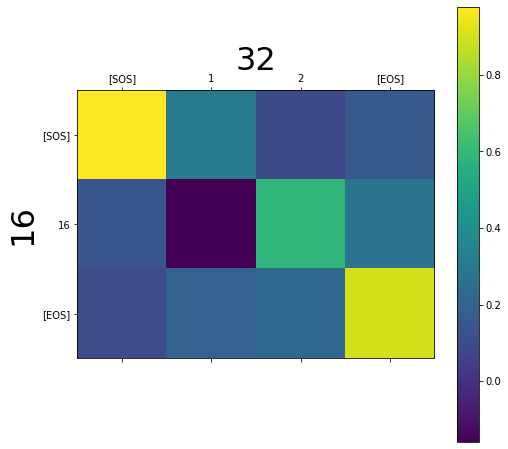

In [63]:
fig = plt.gcf()
fig.set_size_inches(8,8)
ax = plt.gca()
plt.colorbar(ax.matshow(cs_sims), ax=ax)
ax.set_xticks(np.arange(cs_sims.shape[1]))
ax.set_yticks(np.arange(cs_sims.shape[0]))
ax.set_xticklabels(t.decode(second_tokens, decode_special=True).split(' '))
ax.set_yticklabels(t.decode(first_tokens, decode_special=True).split(' '))

plt.xlabel(second_int, fontsize=32)
ax.xaxis.set_label_position('top') 
plt.ylabel(first_int, fontsize=32)

plt.show()

# When the model gets it wrong, what is the probability of the right sequence?

In [64]:
import Levenshtein

In [65]:
target_num = 277337

In [66]:
num_df = problem.form_prediction_df(model, device,  np.array([target_num]), args['model_args']['max_decode_size'], n_beams=50)
num_df['lev_dist'] = num_df.apply(lambda x: Levenshtein.distance(x['pred_str'].replace(' _', ''), x['target_factor_str']), axis=1)
num_df

  0%|          | 0/1 [00:00<?, ?it/s]

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite,lev_dist
0,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",0,-1.165038,[SOS] 10 8 4 17 [EOS] [PAD] [PAD] [PAD] [PAD] [PAD],[277337],277337,1,0,0.000000,True,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,36
1,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",1,-1.835820,[SOS] 7 * 17 * 23 * 3 11 [EOS] [PAD],"[7, 17, 23, 101]",276437,4,4,1.000000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,18
2,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",2,-2.655088,[SOS] 11 * 19 * 1 1 * 1 13 [EOS],"[11, 19, 31, 43]",278597,4,4,1.000000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,12
3,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",3,-2.778504,[SOS] 1 29 * 5 6 13 [EOS] [PAD] [PAD] [PAD],"[59, 4693]",276887,2,1,0.500000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,26
4,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",4,-3.186208,[SOS] 13 * 2 13 * 9 23 [EOS] [PAD] [PAD],"[13, 73, 293]",278057,3,3,1.000000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",45,-7.455013,[SOS] 12 29 * 23 13 [EOS] [PAD] [PAD] [PAD] [PAD],"[389, 703]",273467,2,1,0.500000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,31
46,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",46,-7.466121,[SOS] 18 23 * 16 19 [EOS] [PAD] [PAD] [PAD] [PAD],"[563, 499]",280937,2,2,1.000000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,28
47,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",47,-7.482573,[SOS] 17 * 2 13 * 7 7 [EOS] [PAD] [PAD],"[17, 73, 217]",269297,3,2,0.666667,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,21
48,277337,"[[SOS], 10, 8, 4, 17, [EOS]]",48,-7.491855,[SOS] 1 29 * 5 7 13 [EOS] [PAD] [PAD] [PAD],"[59, 4723]",278657,2,2,1.000000,False,False,False,False,[SOS] 15 13 * 19 29 [EOS],"[463, 599]",2,463,26


In [67]:
num_df['correct_factorization'].sum()

1

In [68]:
problem.form_label(target_num, args['data']['base'])

['[SOS]', 15, 13, '*', 19, 29, '[EOS]']

In [69]:
def get_prob_of_factorization(number, factorization):
    tokens = t.encode(problem.form_input(number, args['data']['base']))
    tensor_input = torch.tensor(tokens).unsqueeze(0).to(device)
    
    factorization_input = torch.tensor(t.encode(factorization)).unsqueeze(0).to(device)
    
    model_output = torch.softmax(model(tensor_input, factorization_input).squeeze(0), dim=-1)
    
    probs = model_output[torch.arange(model_output.size(0)-1),factorization_input[0,1:]]
    
    return probs.log().sum()

In [70]:
get_prob_of_factorization(target_num, num_df.iloc[0]['target_factor_str'].strip().split(' '))

tensor(-4.8159, device='cuda:0', grad_fn=<SumBackward0>)

In [71]:
torch.tensor(t.encode(num_df.iloc[0]['target_factor_str'].strip().split(' '))).unsqueeze(0).to(device)

tensor([[33, 15, 13, 30, 19, 29, 32]], device='cuda:0')